In [1]:
# Instala librerías necesarias
!pip install torch


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importa las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

### A - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,5,5,1]

### I - Grilla de 5 x 5:

Época 0, Pérdida total: 0.3772597014904022
Época 10, Pérdida total: 0.151262104511261
Época 20, Pérdida total: 0.06550406664609909
Época 30, Pérdida total: 0.03243154287338257
Época 40, Pérdida total: 0.02317228727042675
Época 50, Pérdida total: 0.015057464130222797
Época 60, Pérdida total: 0.012060815468430519
Época 70, Pérdida total: 0.011236014775931835
Época 80, Pérdida total: 0.010404244996607304
Época 90, Pérdida total: 0.009822195395827293
Época 100, Pérdida total: 0.009370766580104828
Época 110, Pérdida total: 0.008959949016571045
Época 120, Pérdida total: 0.008580825291574001
Época 130, Pérdida total: 0.008233143948018551
Época 140, Pérdida total: 0.007911771535873413
Época 150, Pérdida total: 0.007614141330122948
Época 160, Pérdida total: 0.007338567636907101
Época 170, Pérdida total: 0.0070833489298820496
Época 180, Pérdida total: 0.006846711039543152
Época 190, Pérdida total: 0.006627021823078394
Época 200, Pérdida total: 0.006422747392207384
Época 210, Pérdida total: 0.006

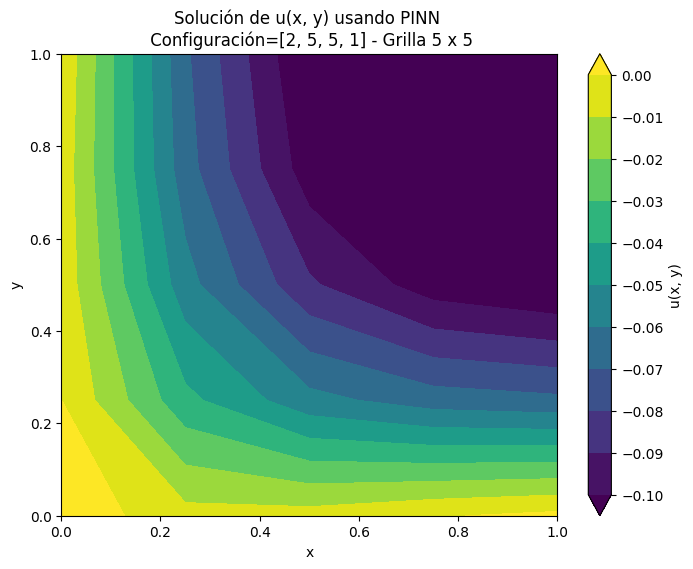

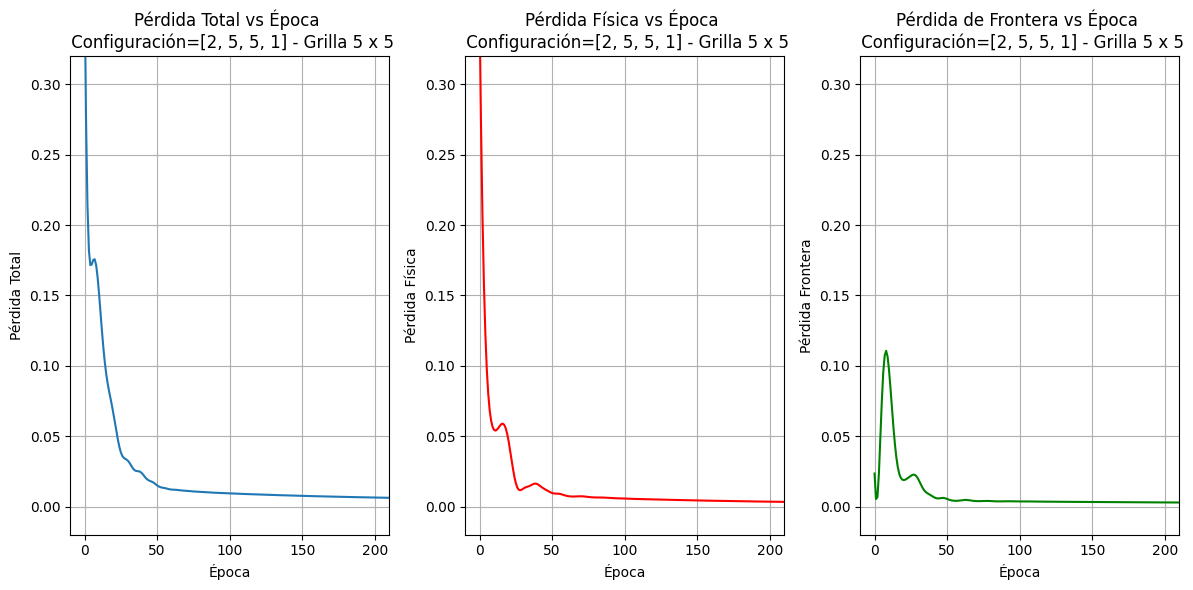

In [60]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear la grilla de puntos de entrenamiento
x_vals = np.linspace(0, 1, 5)
y_vals = np.linspace(0, 1, 5)
x, y = np.meshgrid(x_vals, y_vals)
xy_interior = torch.tensor(np.c_[x.ravel(), y.ravel()], dtype=torch.float32, requires_grad=True)

# Crear puntos de la frontera
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 10 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con contourf
def plot_solution_contourf(u_pred):
    Z = u_pred.reshape((5, 5))  # Reshape para formar la grilla 5x5

    plt.figure(figsize=(8, 6))
    cp = plt.contourf(np.linspace(0, 1, 5), np.linspace(0, 1, 5), Z, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos de la cuadrícula interior
with torch.no_grad():
    u_pred = model(xy_interior).numpy()

# Graficar la solución con contourf
plot_solution_contourf(u_pred)

# Graficar las pérdidas
plot_losses()

### II - Grilla de 10 x 10:

Época 0, Pérdida total: 0.2694321870803833
Época 10, Pérdida total: 0.0787968710064888
Época 20, Pérdida total: 0.018040824681520462
Época 30, Pérdida total: 0.017855288460850716
Época 40, Pérdida total: 0.010376052930951118
Época 50, Pérdida total: 0.0072557213716208935
Época 60, Pérdida total: 0.0054067992605268955
Época 70, Pérdida total: 0.0044205766171216965
Época 80, Pérdida total: 0.003976637497544289
Época 90, Pérdida total: 0.0037656505592167377
Época 100, Pérdida total: 0.0036330728325992823
Época 110, Pérdida total: 0.003519154852256179
Época 120, Pérdida total: 0.003411673940718174
Época 130, Pérdida total: 0.0033092107623815536
Época 140, Pérdida total: 0.0032121294643729925
Época 150, Pérdida total: 0.003120089415460825
Época 160, Pérdida total: 0.0030328354332596064
Época 170, Pérdida total: 0.0029502997640520334
Época 180, Pérdida total: 0.0028723576106131077
Época 190, Pérdida total: 0.0027987919747829437
Época 200, Pérdida total: 0.002729338826611638
Época 210, Pérdid

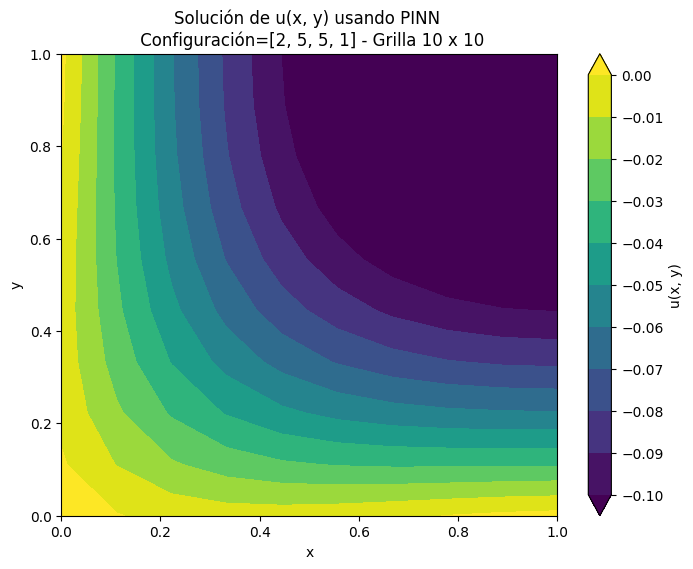

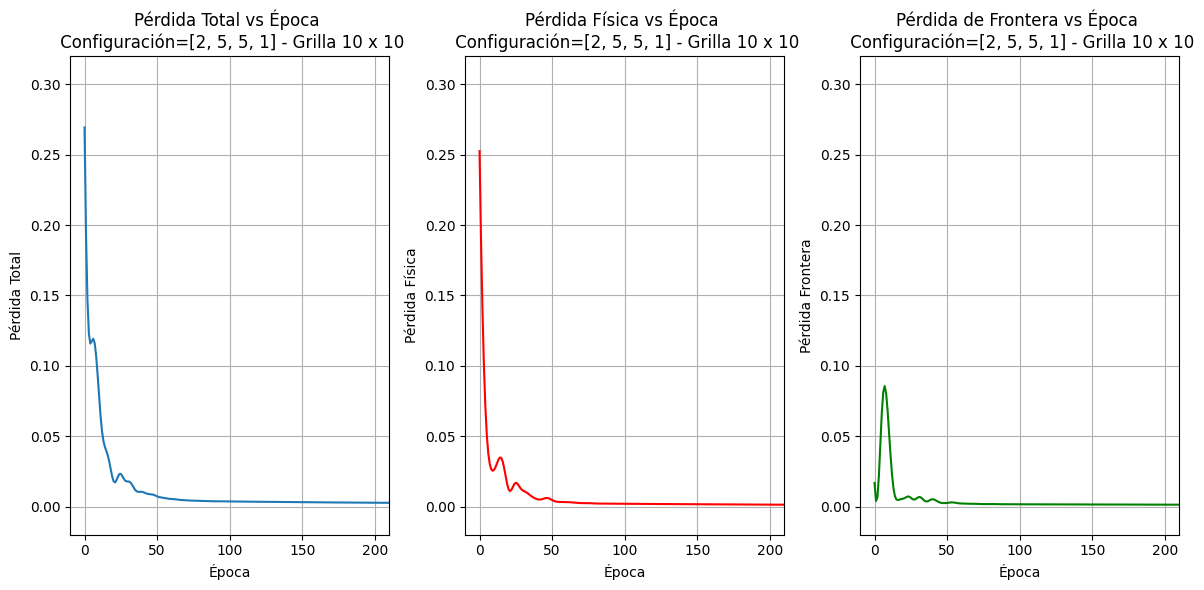

In [59]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear la grilla de puntos de entrenamiento (10x10)
x_vals = np.linspace(0, 1, 10)
y_vals = np.linspace(0, 1, 10)
x, y = np.meshgrid(x_vals, y_vals)
xy_interior = torch.tensor(np.c_[x.ravel(), y.ravel()], dtype=torch.float32, requires_grad=True)

# Crear puntos de la frontera
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 10 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con contourf
def plot_solution_contourf(u_pred):
    Z = u_pred.reshape((10, 10))  # Reshape para formar la grilla 10x10

    plt.figure(figsize=(8, 6))
    cp = plt.contourf(np.linspace(0, 1, 10), np.linspace(0, 1, 10), Z, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos de la cuadrícula interior
with torch.no_grad():
    u_pred = model(xy_interior).numpy()

# Graficar la solución con contourf
plot_solution_contourf(u_pred)

# Graficar las pérdidas
plot_losses()

### III - Grilla de 20 x 20:

Época 0, Pérdida total: 0.3227965235710144
Época 10, Pérdida total: 0.13272510468959808
Época 20, Pérdida total: 0.06669709086418152
Época 30, Pérdida total: 0.04162396118044853
Época 40, Pérdida total: 0.02827240526676178
Época 50, Pérdida total: 0.02018614113330841
Época 60, Pérdida total: 0.015362954698503017
Época 70, Pérdida total: 0.012106964364647865
Época 80, Pérdida total: 0.010360760614275932
Época 90, Pérdida total: 0.008953682146966457
Época 100, Pérdida total: 0.008105125278234482
Época 110, Pérdida total: 0.007494448684155941
Época 120, Pérdida total: 0.006990174762904644
Época 130, Pérdida total: 0.006563868839293718
Época 140, Pérdida total: 0.006187921855598688
Época 150, Pérdida total: 0.005852188915014267
Época 160, Pérdida total: 0.005549713037908077
Época 170, Pérdida total: 0.00527449045330286
Época 180, Pérdida total: 0.005022396333515644
Época 190, Pérdida total: 0.004790309816598892
Época 200, Pérdida total: 0.004575836472213268
Época 210, Pérdida total: 0.0043

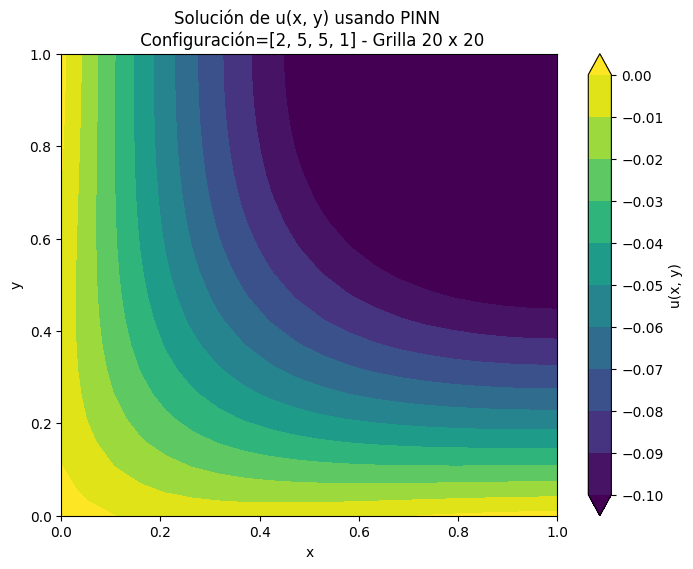

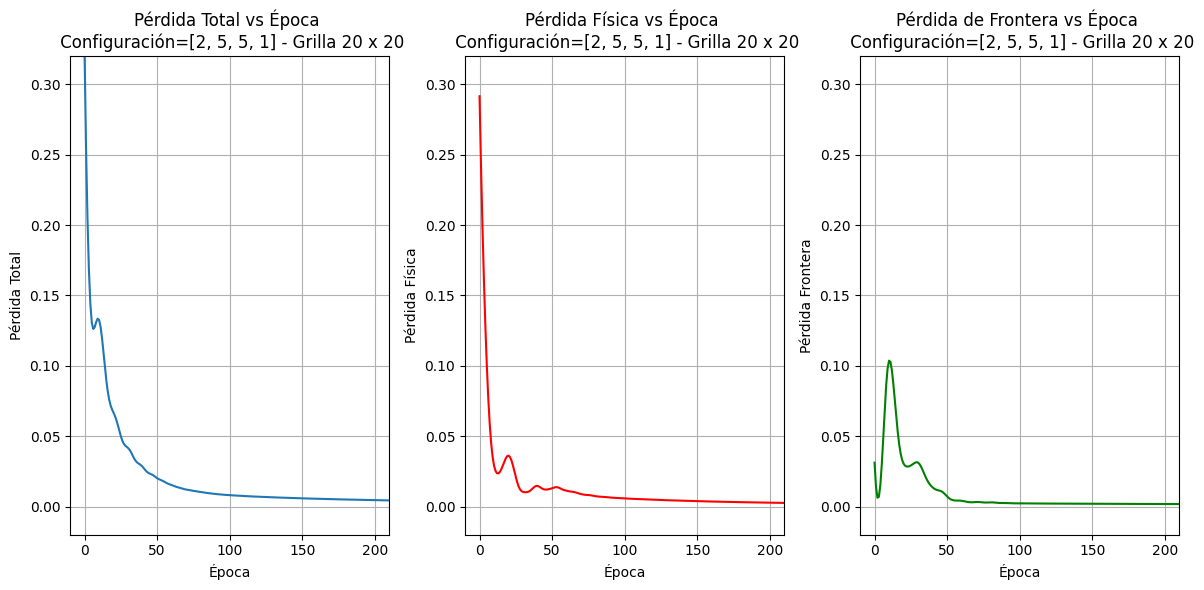

In [58]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear la grilla de puntos de entrenamiento (20x20)
x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)
x, y = np.meshgrid(x_vals, y_vals)
xy_interior = torch.tensor(np.c_[x.ravel(), y.ravel()], dtype=torch.float32, requires_grad=True)

# Crear puntos de la frontera
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 2000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 10 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con contourf
def plot_solution_contourf(u_pred):
    Z = u_pred.reshape((20, 20))  # Reshape para formar la grilla 20x20

    plt.figure(figsize=(8, 6))
    cp = plt.contourf(np.linspace(0, 1, 20), np.linspace(0, 1, 20), Z, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.xlim([-10, 210])
    plt.ylim([-0.02, 0.32])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos de la cuadrícula interior
with torch.no_grad():
    u_pred = model(xy_interior).numpy()

# Graficar la solución con contourf
plot_solution_contourf(u_pred)

# Graficar las pérdidas
plot_losses()

## B - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,5,5,1] utilizando muestreos aleatorios de los puntos de colocación.

### I - Cantidad de puntos de colocación aleatorios equivalente a grilla de 5x5.

Época 0, Pérdida total: 0.5018723607063293
Época 10, Pérdida total: 0.05505283921957016
Época 20, Pérdida total: 0.018352443352341652
Época 30, Pérdida total: 0.006998266559094191
Época 40, Pérdida total: 0.008136454969644547
Época 50, Pérdida total: 0.005961872637271881
Época 60, Pérdida total: 0.005586279556155205
Época 70, Pérdida total: 0.005330896005034447
Época 80, Pérdida total: 0.005049141123890877
Época 90, Pérdida total: 0.004881109111011028
Época 100, Pérdida total: 0.004748125094920397
Época 110, Pérdida total: 0.004625294357538223
Época 120, Pérdida total: 0.004509839694947004
Época 130, Pérdida total: 0.004398128017783165
Época 140, Pérdida total: 0.004287075251340866
Época 150, Pérdida total: 0.00417387206107378
Época 160, Pérdida total: 0.004055807366967201
Época 170, Pérdida total: 0.003929969388991594
Época 180, Pérdida total: 0.003792958566918969
Época 190, Pérdida total: 0.003640944603830576
Época 200, Pérdida total: 0.0034700576215982437
Época 210, Pérdida total: 0

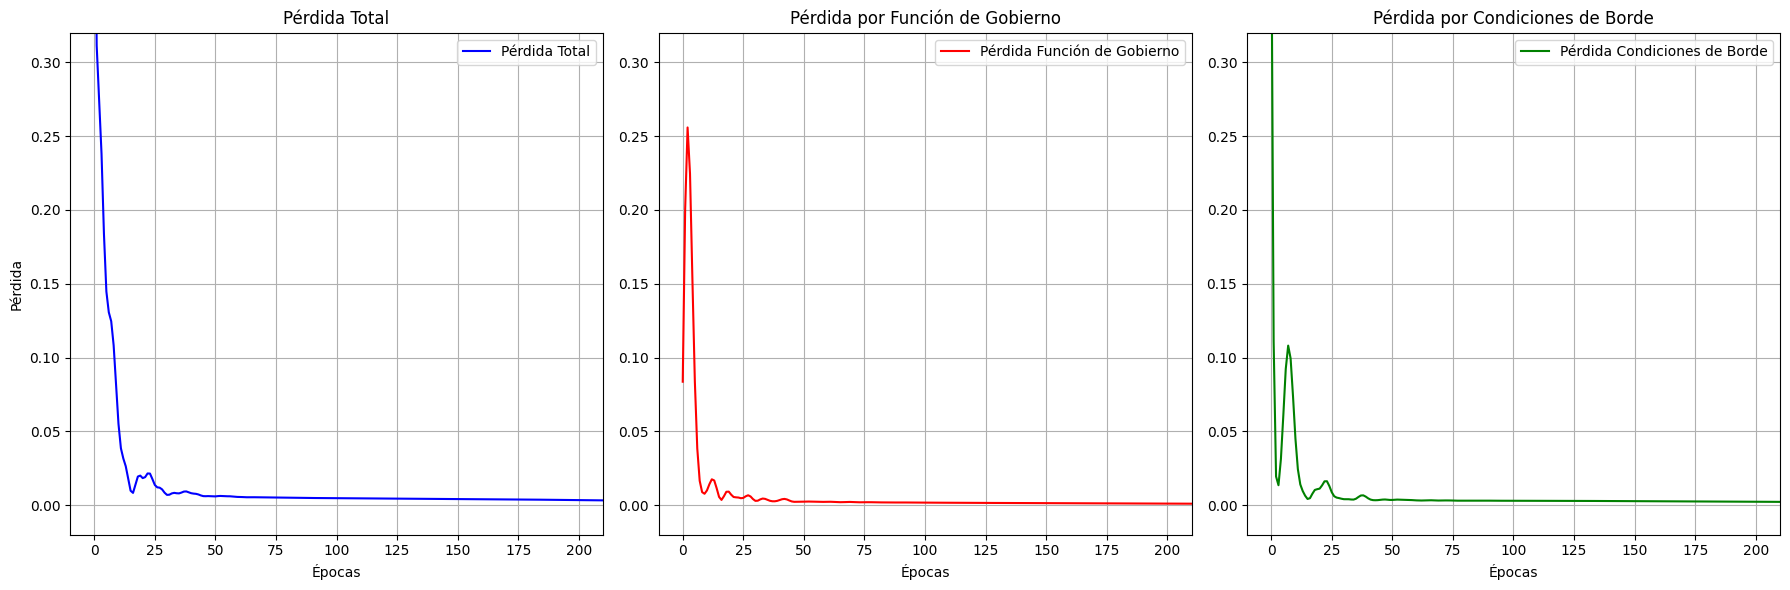

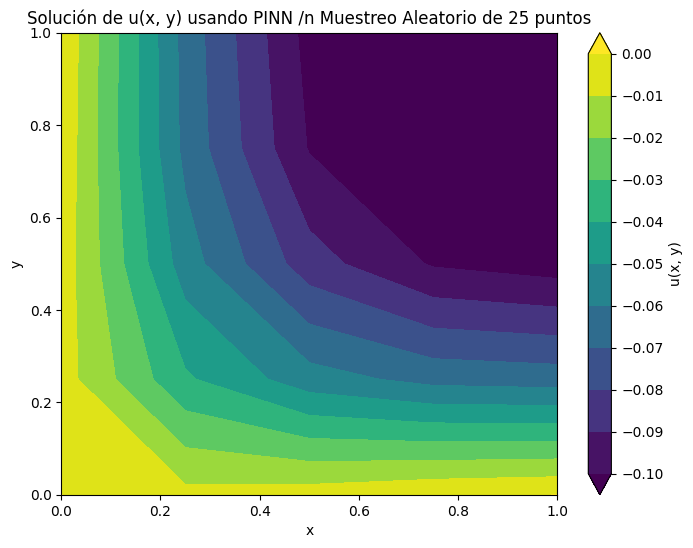

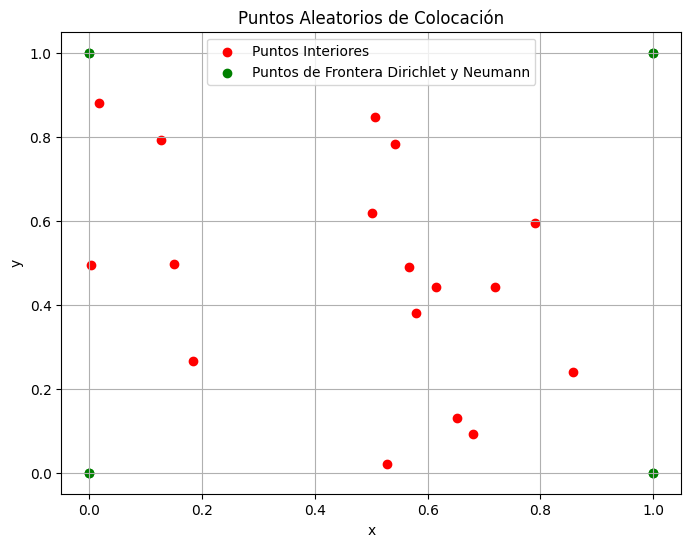

In [ ]:
# Definición de la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.model(x)

# Función de pérdida para el interior
def loss_fn(xy_interior):
    u = model(xy_interior)
    u_x = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
    u_y = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]
    u_xx = torch.autograd.grad(u_x, xy_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, xy_interior, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    return torch.mean((laplace_u - source_term) ** 2)


# Función de pérdida para las condiciones de frontera
def boundary_loss(xy_boundary, boundary_type):
    u_boundary = model(xy_boundary)
    if boundary_type == "Dirichlet":
        return torch.mean((u_boundary) ** 2)
    elif boundary_type == "Neumann_x":
        u_x = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 0]
        return torch.mean((u_x) ** 2)
    elif boundary_type == "Neumann_y":
        u_y = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 1]
        return torch.mean((u_y) ** 2)

# Crear puntos del dominio
num_samples = 25  # Total de puntos
num_boundary_samples = int(0.32 * num_samples)  # 32% para la frontera
num_interior_samples = num_samples - num_boundary_samples  # 68% para el interior

# Crear puntos interiores
xy_interior_random = torch.rand(num_interior_samples, 2, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras
x_vals = np.linspace(0, 1, 2)
y_vals = np.linspace(0, 1, 2)

xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)

# Crear el modelo y el optimizador
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
epochs = 2000
losses_total = []
losses_interior = []
losses_boundary = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdida en el interior del dominio (función de gobierno)
    loss_interior = loss_fn(xy_interior_random)
    
    # Pérdidas de frontera (sin discriminar tipo)
    loss_boundary = (
        boundary_loss(xy_b0, "Dirichlet") +
        boundary_loss(xy_b1, "Dirichlet") +
        boundary_loss(xy_nx, "Neumann_x") +
        boundary_loss(xy_ny, "Neumann_y")
    )
    
    # Pérdida total
    loss = loss_interior + loss_boundary
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary.item())

    if epoch % 10 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar las pérdidas en subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pérdida total
axes[0].plot(losses_total, label="Pérdida Total", color="blue")
axes[0].set_title("Pérdida Total")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Pérdida")
axes[0].grid(True)
axes[0].set_xlim([-10, 210])
axes[0].set_ylim([-0.02, 0.32])
axes[0].legend()

# Pérdida función de gobierno
axes[1].plot(losses_interior, label="Pérdida Función de Gobierno", color="red")
axes[1].set_title("Pérdida por Función de Gobierno")
axes[1].set_xlabel("Épocas")
axes[1].grid(True)
axes[1].set_xlim([-10, 210])
axes[1].set_ylim([-0.02, 0.32])
axes[1].legend()

# Pérdida condiciones de borde
axes[2].plot(losses_boundary, label="Pérdida Condiciones de Borde", color="green")
axes[2].set_title("Pérdida por Condiciones de Borde")
axes[2].set_xlabel("Épocas")
axes[2].grid(True)
axes[2].set_xlim([-10, 210])
axes[2].set_ylim([-0.02, 0.32])
axes[2].legend()

plt.tight_layout()
plt.show()

# Evaluar la solución del modelo
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)
xy_eval = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)
u_pred = model(xy_eval).detach().numpy().reshape(5, 5)

# Graficar la solución
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, u_pred, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN /n Muestreo Aleatorio de 25 puntos")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Graficar los puntos de colocación aleatoria
plt.figure(figsize=(8, 6))

# Puntos interiores (rojos)
plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos Interiores')

# Puntos de frontera (verdes)
plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Puntos de Frontera Dirichlet y Neumann')
plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green')
plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='green')
plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='green')

# Configuraciones del gráfico
plt.title("Puntos Aleatorios de Colocación: 25")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### II - Cantidad de puntos de colocación aleatorios equivalente a grilla de 10x10.

Época 0, Pérdida total: 0.2223861962556839
Época 100, Pérdida total: 0.003381141694262624
Época 200, Pérdida total: 0.001541067729704082
Época 300, Pérdida total: 0.0009760392713360488
Época 400, Pérdida total: 0.0007301160367205739
Época 500, Pérdida total: 0.0006052542012184858
Época 600, Pérdida total: 0.0004997660871595144
Época 700, Pérdida total: 0.00047260819701477885
Época 800, Pérdida total: 0.0004075930337421596
Época 900, Pérdida total: 0.00047064866521395743
Época 1000, Pérdida total: 0.0003716235514730215
Época 1100, Pérdida total: 0.0003464149485807866
Época 1200, Pérdida total: 0.00033484637970104814
Época 1300, Pérdida total: 0.00033528960193507373
Época 1400, Pérdida total: 0.00033691010321490467
Época 1500, Pérdida total: 0.0003290404856670648
Época 1600, Pérdida total: 0.000326118286466226
Época 1700, Pérdida total: 0.00032452103914693
Época 1800, Pérdida total: 0.0003664124815259129
Época 1900, Pérdida total: 0.00032566345180384815


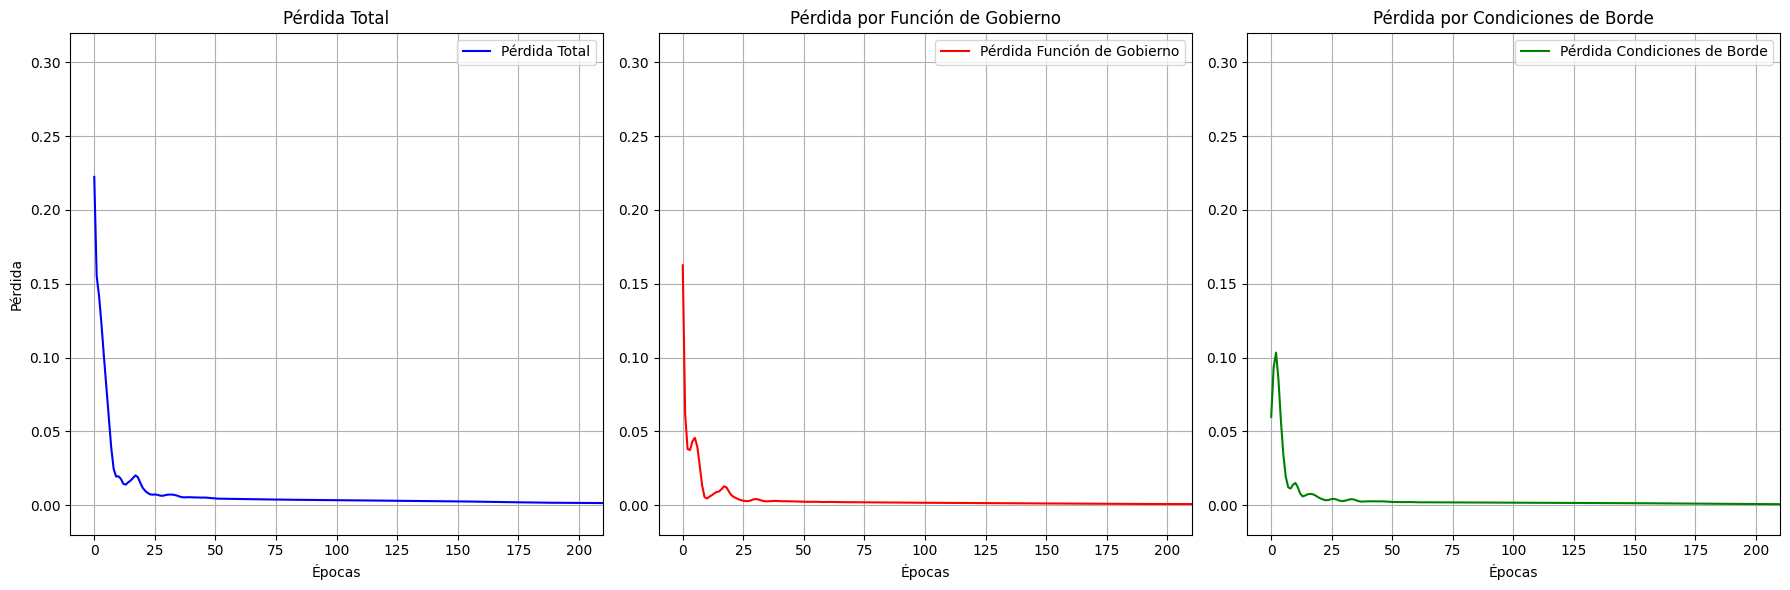

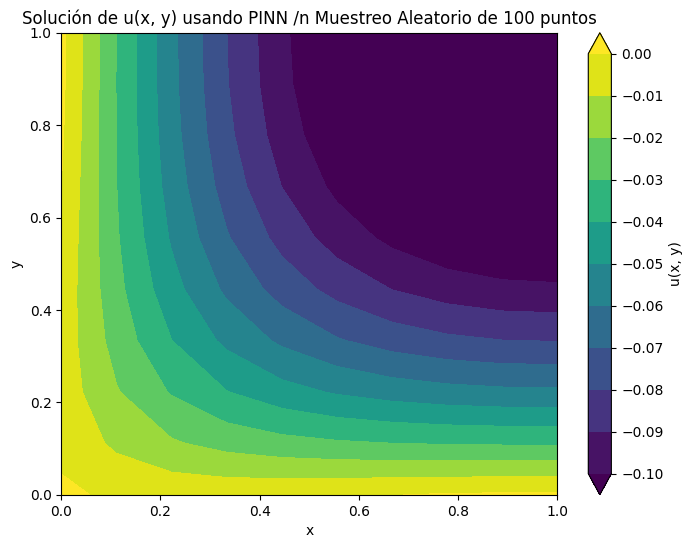

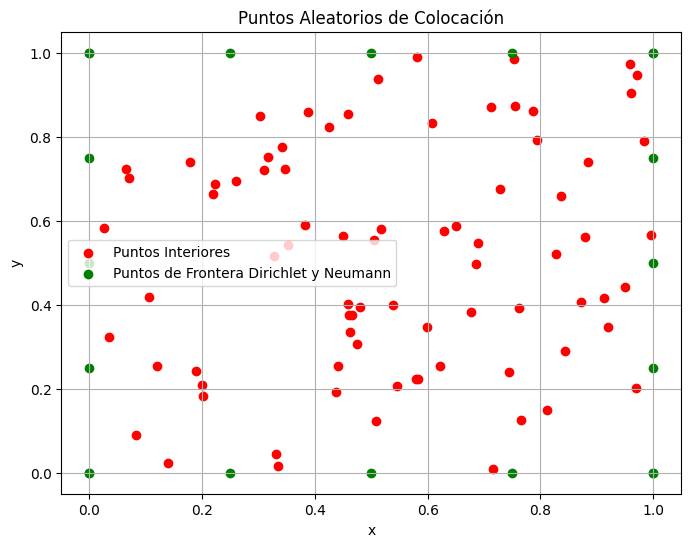

In [ ]:
# Definición de la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.model(x)

# Función de pérdida para el interior
def loss_fn(xy_interior):
    u = model(xy_interior)
    u_x = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
    u_y = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]
    u_xx = torch.autograd.grad(u_x, xy_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, xy_interior, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    return torch.mean((laplace_u - source_term) ** 2)


# Función de pérdida para las condiciones de frontera
def boundary_loss(xy_boundary, boundary_type):
    u_boundary = model(xy_boundary)
    if boundary_type == "Dirichlet":
        return torch.mean((u_boundary) ** 2)
    elif boundary_type == "Neumann_x":
        u_x = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 0]
        return torch.mean((u_x) ** 2)
    elif boundary_type == "Neumann_y":
        u_y = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 1]
        return torch.mean((u_y) ** 2)

# Crear puntos del dominio
num_samples = 100  # Total de puntos
num_boundary_samples = int(0.20 * num_samples)  # 20% para la frontera
num_interior_samples = num_samples - num_boundary_samples  # 80% para el interior

# Crear puntos interiores
xy_interior_random = torch.rand(num_interior_samples, 2, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras
x_vals = np.linspace(0, 1, 5)
y_vals = np.linspace(0, 1, 5)

xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)

# Crear el modelo y el optimizador
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
epochs = 2000
losses_total = []
losses_interior = []
losses_boundary = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdida en el interior del dominio (función de gobierno)
    loss_interior = loss_fn(xy_interior_random)
    
    # Pérdidas de frontera (sin discriminar tipo)
    loss_boundary = (
        boundary_loss(xy_b0, "Dirichlet") +
        boundary_loss(xy_b1, "Dirichlet") +
        boundary_loss(xy_nx, "Neumann_x") +
        boundary_loss(xy_ny, "Neumann_y")
    )
    
    # Pérdida total
    loss = loss_interior + loss_boundary
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary.item())

    if epoch % 100 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar las pérdidas en subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pérdida total
axes[0].plot(losses_total, label="Pérdida Total", color="blue")
axes[0].set_title("Pérdida Total")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Pérdida")
axes[0].grid(True)
axes[0].set_xlim([-10, 210])
axes[0].set_ylim([-0.02, 0.32])
axes[0].legend()

# Pérdida función de gobierno
axes[1].plot(losses_interior, label="Pérdida Función de Gobierno", color="red")
axes[1].set_title("Pérdida por Función de Gobierno")
axes[1].set_xlabel("Épocas")
axes[1].grid(True)
axes[1].set_xlim([-10, 210])
axes[1].set_ylim([-0.02, 0.32])
axes[1].legend()

# Pérdida condiciones de borde
axes[2].plot(losses_boundary, label="Pérdida Condiciones de Borde", color="green")
axes[2].set_title("Pérdida por Condiciones de Borde")
axes[2].set_xlabel("Épocas")
axes[2].grid(True)
axes[2].set_xlim([-10, 210])
axes[2].set_ylim([-0.02, 0.32])
axes[2].legend()

plt.tight_layout()
plt.show()

# Evaluar la solución del modelo
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)
xy_eval = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)
u_pred = model(xy_eval).detach().numpy().reshape(10, 10)

# Graficar la solución
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, u_pred, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN /n Muestreo Aleatorio de 100 puntos")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Graficar los puntos de colocación aleatoria
plt.figure(figsize=(8, 6))

# Puntos interiores (rojos)
plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos Interiores')

# Puntos de frontera (verdes)
plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Puntos de Frontera Dirichlet y Neumann')
plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green')
plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='green')
plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='green')

# Configuraciones del gráfico
plt.title("Puntos Aleatorios de Colocación: 100")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### III - Cantidad de puntos de colocación aleatorios equivalente a grilla de 20x20.

Época 0, Pérdida total: 0.28710538148880005
Época 100, Pérdida total: 0.003556907409802079
Época 200, Pérdida total: 0.0018901301082223654
Época 300, Pérdida total: 0.0009731025202199817
Época 400, Pérdida total: 0.0007833341951481998
Época 500, Pérdida total: 0.0006157541647553444
Época 600, Pérdida total: 0.0005543249426409602
Época 700, Pérdida total: 0.00045513216173276305
Época 800, Pérdida total: 0.00041467396658845246
Época 900, Pérdida total: 0.00046105022192932665
Época 1000, Pérdida total: 0.0003992664278484881
Época 1100, Pérdida total: 0.0003920875315088779
Época 1200, Pérdida total: 0.00038826142554171383
Época 1300, Pérdida total: 0.000385399122023955
Época 1400, Pérdida total: 0.0003955813590437174
Época 1500, Pérdida total: 0.00038520811358466744
Época 1600, Pérdida total: 0.0003826639731414616
Época 1700, Pérdida total: 0.00038073729956522584
Época 1800, Pérdida total: 0.002785623073577881
Época 1900, Pérdida total: 0.0003819740959443152


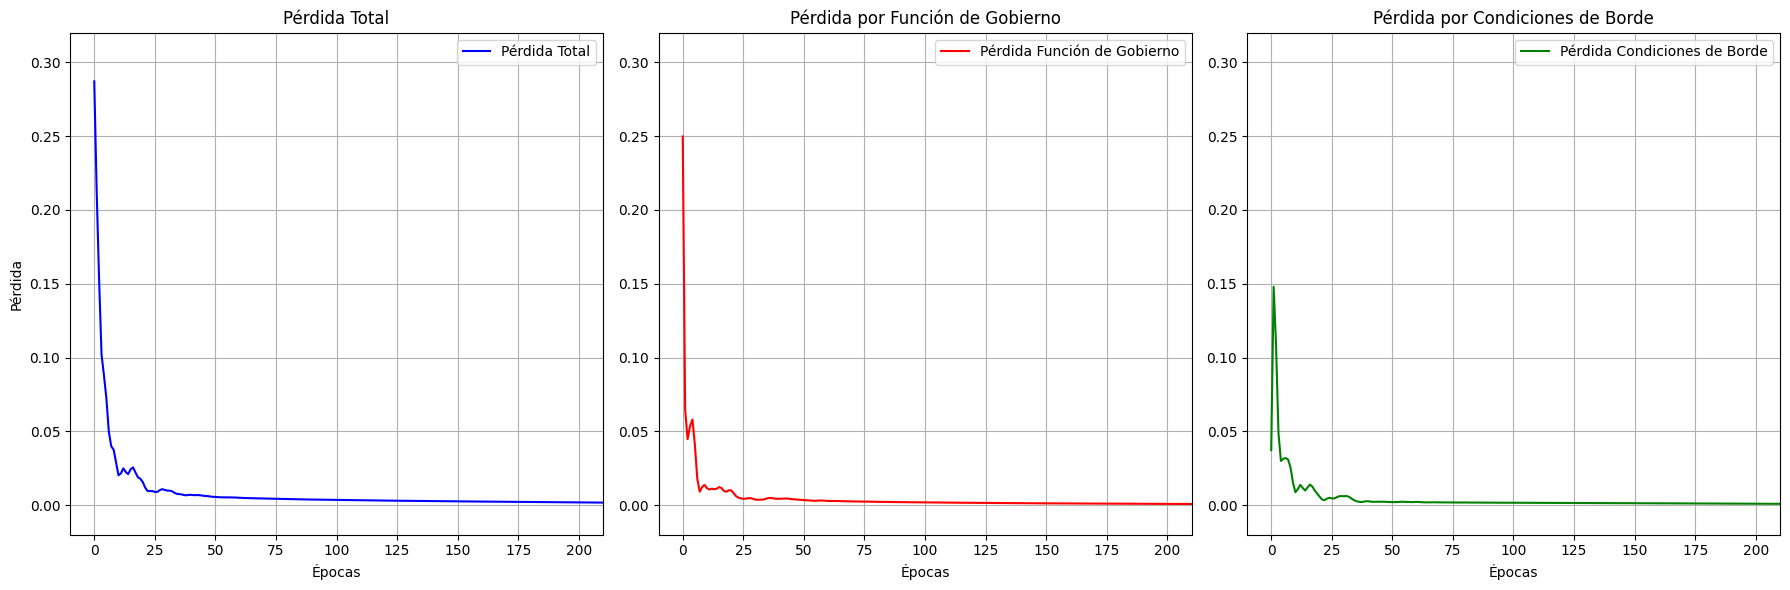

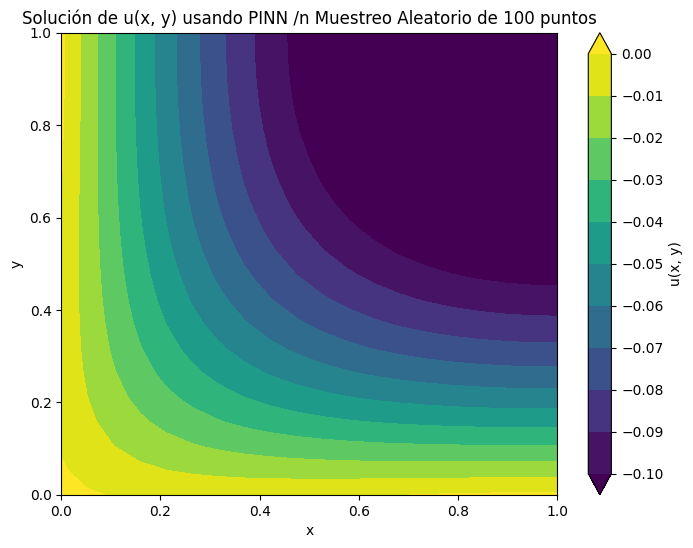

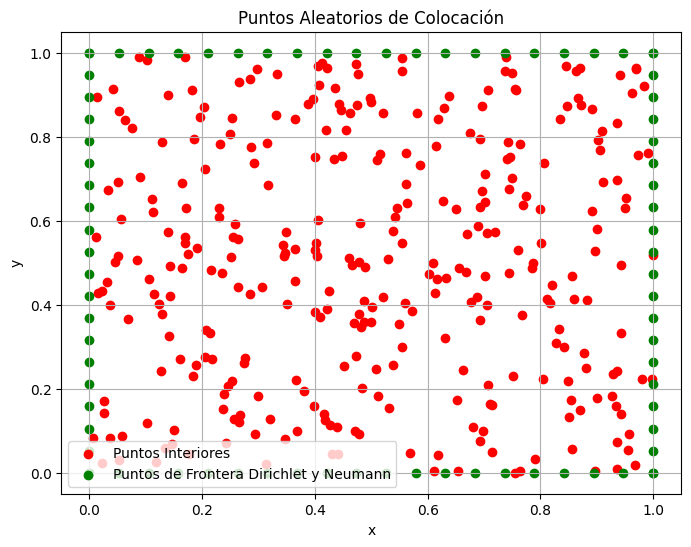

In [ ]:
# Definición de la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.model(x)

# Función de pérdida para el interior
def loss_fn(xy_interior):
    u = model(xy_interior)
    u_x = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0]
    u_y = torch.autograd.grad(u, xy_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]
    u_xx = torch.autograd.grad(u_x, xy_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y, xy_interior, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    return torch.mean((laplace_u - source_term) ** 2)


# Función de pérdida para las condiciones de frontera
def boundary_loss(xy_boundary, boundary_type):
    u_boundary = model(xy_boundary)
    if boundary_type == "Dirichlet":
        return torch.mean((u_boundary) ** 2)
    elif boundary_type == "Neumann_x":
        u_x = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 0]
        return torch.mean((u_x) ** 2)
    elif boundary_type == "Neumann_y":
        u_y = torch.autograd.grad(u_boundary, xy_boundary, grad_outputs=torch.ones_like(u_boundary), create_graph=True)[0][:, 1]
        return torch.mean((u_y) ** 2)

# Crear puntos del dominio
num_samples = 400  # Total de puntos
num_boundary_samples = int(0.20 * num_samples)  # 20% para la frontera
num_interior_samples = num_samples - num_boundary_samples  # 80% para el interior

# Crear puntos interiores
xy_interior_random = torch.rand(num_interior_samples, 2, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras
x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)

xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)

# Crear el modelo y el optimizador
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
epochs = 2000
losses_total = []
losses_interior = []
losses_boundary = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdida en el interior del dominio (función de gobierno)
    loss_interior = loss_fn(xy_interior_random)
    
    # Pérdidas de frontera (sin discriminar tipo)
    loss_boundary = (
        boundary_loss(xy_b0, "Dirichlet") +
        boundary_loss(xy_b1, "Dirichlet") +
        boundary_loss(xy_nx, "Neumann_x") +
        boundary_loss(xy_ny, "Neumann_y")
    )
    
    # Pérdida total
    loss = loss_interior + loss_boundary
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary.item())

    if epoch % 100 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar las pérdidas en subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pérdida total
axes[0].plot(losses_total, label="Pérdida Total", color="blue")
axes[0].set_title("Pérdida Total")
axes[0].set_xlabel("Épocas")
axes[0].set_ylabel("Pérdida")
axes[0].grid(True)
axes[0].set_xlim([-10, 210])
axes[0].set_ylim([-0.02, 0.32])
axes[0].legend()

# Pérdida función de gobierno
axes[1].plot(losses_interior, label="Pérdida Función de Gobierno", color="red")
axes[1].set_title("Pérdida por Función de Gobierno")
axes[1].set_xlabel("Épocas")
axes[1].grid(True)
axes[1].set_xlim([-10, 210])
axes[1].set_ylim([-0.02, 0.32])
axes[1].legend()

# Pérdida condiciones de borde
axes[2].plot(losses_boundary, label="Pérdida Condiciones de Borde", color="green")
axes[2].set_title("Pérdida por Condiciones de Borde")
axes[2].set_xlabel("Épocas")
axes[2].grid(True)
axes[2].set_xlim([-10, 210])
axes[2].set_ylim([-0.02, 0.32])
axes[2].legend()

plt.tight_layout()
plt.show()

# Evaluar la solución del modelo
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)
xy_eval = torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float32)
u_pred = model(xy_eval).detach().numpy().reshape(20, 20)

# Graficar la solución
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, u_pred, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN /n Muestreo Aleatorio de 400 puntos")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Graficar los puntos de colocación aleatoria
plt.figure(figsize=(8, 6))

# Puntos interiores (rojos)
plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos Interiores')

# Puntos de frontera (verdes)
plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Puntos de Frontera Dirichlet y Neumann')
plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green')
plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='green')
plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='green')

# Configuraciones del gráfico
plt.title("Puntos Aleatorios de Colocación: 400")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()